In [21]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

In [22]:
treeH = read_img(spei_path+'African_th2019_001_230525.tif')[0]
tc_planet = read_img(spei_path+'Africa_tc2019_mosaic_001_fillNaN_231215.tif')[0]
treeH[treeH==0]=np.nan
tc_planet=tc_planet.astype(np.float32)
tc_planet[tc_planet==0]=np.nan
tc_planet[tc_planet>100]=np.nan

In [23]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

In [24]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [25]:
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [26]:
#-----------------------------paired sites-----------------------------
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    std=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                std[i,j]=np.std(gc.nanravel(res_mask))
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    std[i,j]=np.std(gc.nanravel(dt1))#calculate the mean value
                    loc[i,j]=key+1
                else:
                    std[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return std
dist_pool=[DEAA*mask,DAA*mask]
res_pool=[treeH,tc_planet,dem,slope] #protect need conver to fraction
dist_name=['DEAA','DAA']
res_name=['th_std','tc_std','dem','slope']
# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(2):
    for j in range(4):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('pattern-drivers_SD_{}_{}_0.25deg_240504.npy'.format(dist_name[i],res_name[j]))
aa_name

['pattern-drivers_SD_DEAA_th_std_0.25deg_240504.npy',
 'pattern-drivers_SD_DEAA_tc_std_0.25deg_240504.npy',
 'pattern-drivers_SD_DEAA_dem_0.25deg_240504.npy',
 'pattern-drivers_SD_DEAA_slope_0.25deg_240504.npy',
 'pattern-drivers_SD_DAA_th_std_0.25deg_240504.npy',
 'pattern-drivers_SD_DAA_tc_std_0.25deg_240504.npy',
 'pattern-drivers_SD_DAA_dem_0.25deg_240504.npy',
 'pattern-drivers_SD_DAA_slope_0.25deg_240504.npy']

In [27]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(drv_path+aa_name[i],kk)

执行任务0 (17204)...
执行任务1 (17204)...
执行任务2 (17204)...
执行任务3 (17204)...
执行任务4 (17204)...
执行任务5 (17204)...
执行任务6 (17204)...
执行任务7 (17204)...


In [28]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_DEAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_DAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_DEAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_DAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [29]:
res_name1=['th_std','tc_std']
# ['pattern-drivers_SD_DEAA_th_std_0.25deg_240104.npy',
delta=[]
for i in range(2):
    f1=np.load(drv_path+'pattern-drivers_SD_DEAA_{}_0.25deg_240504.npy'.format(res_name1[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'pattern-drivers_SD_DAA_{}_0.25deg_240504.npy'.format(res_name1[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff) #Δ
len(delta)

2

In [30]:
#array to list，delete NAN and ravel.
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

pd_delta=[]
for i in range(2):
    pd_delta.append(kill_nan(delta[i]))

pd_delta=list(map(list, zip(*pd_delta)))#list转置
np.array(pd_delta).shape

(2742, 2)

In [31]:
#计算标准误方法1
se1=[]
for i in range(2):
    se1.append(np.std(pd_delta[i])/np.sqrt(len(pd_delta[i])))
se1

[0.3375901031323786, 0.39183807049402347]

In [32]:
#计算均值
mean=[]
for i in range(2):
    mean.append(np.mean(pd_delta[i]))
mean

[0.16353046894073486, 0.6397411823272705]

In [33]:
#-----------------------------significants-----------------------------
pp_value=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.load(drv_path+'pattern-drivers_SD_DEAA_{}_0.25deg_240504.npy'.format(res_name1[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'pattern-drivers_SD_DAA_{}_0.25deg_240504.npy'.format(res_name1[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value.append(p)
pp_value #p value of ndvi_res and csif_res

[3.4776111326792643e-19, 1.6228166863101364e-06]

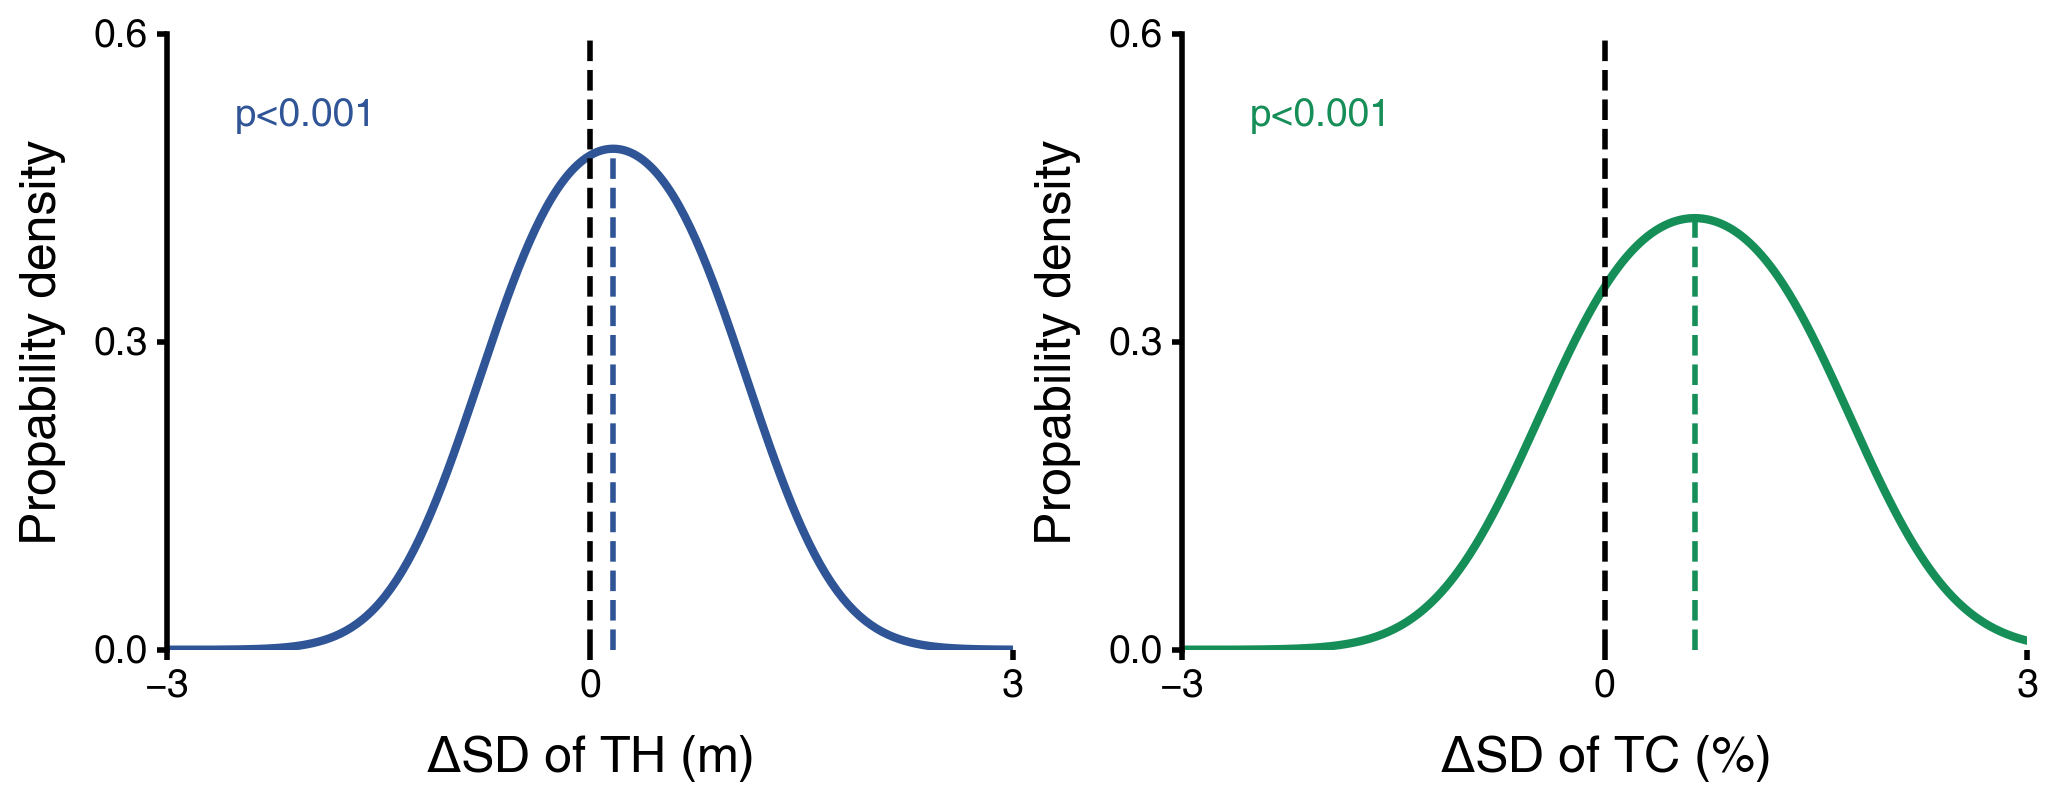

In [35]:
#-----------------------------pdf-----------------------------
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.2,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs
#cl1 = np.array([(82,160,134),(244,132,102)])
#cl=cl1/255
#cl=['C0','salmon']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label=['$\Delta$SD of TH (m)','$\Delta$SD of TC (%)']

cl1 = np.array([(47,85,151)])
cl2 = np.array([(22,142,88)])
cl=[cl1/255,cl2/255]

x1=np.linspace(-10,10,1000)
x2=np.linspace(-5,5,1000)
x=[x1,x2]

for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    mean=np.nanmean(pd_delta[i])
    delta_rav=gc.nanravel(pd_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x[i])
    z_mean=kenal.evaluate(mean)
    ax.plot(x[i],z,lw=3,color=cl[i],label=label[i])
    ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    if pp_value[i]<0.001:
        ax.text(0.08,0.85, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[i])
    elif pp_value[i]<0.01:
        ax.text(0.08,0.85, '{:.2f} ***'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i])
    elif pp_value[i]<0.05:
        ax.text(0.08,0.85, '{:.2f} ***'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i])
    else:
        ax.text(0.08,0.85, '{:.3f} (p={:.2f})'.format(mean,tx[i],pp_value[i]), fontsize=14,transform = ax.transAxes,color=cl[i])
    if i ==0:
        ax.vlines(0,0,0.6,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.6)
        ax.set_yticks(np.arange(0,0.601,0.3))
        ax.set_xlim(-3,3)
        ax.set_xticks(np.arange(-3,3.01,3))
    if i==1:
        ax.vlines(0,0,0.6,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.6)
        ax.set_yticks(np.arange(0,0.61,0.3))
        ax.set_xlim(-3,3)
        ax.set_xticks(np.arange(-3,3.01,3))


    ax.set_ylabel('Propability density',labelpad=10)
    ax.set_xlabel(label[i],labelpad=10)
    ax.xaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)

    ax.tick_params(labelsize=14)
    ax.yaxis.label.set_size(18)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))